In [6]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

In [2]:
pd.options.display.max_rows = 1000

In [3]:
df = pd.read_csv('./data/train.csv')

In [384]:
def parse_sentence(sentence):
    prev_word, prev_pos = '', ''
    nouns = []
    buff = ''
    ret = []
    condition = False
    idx = 0
    n_words = {}
    #for word, pos in mecab.pos(df[df['id'] == 312232].iloc[0].text):
    for word, pos in mecab.pos(sentence):

        if pos in ('SF') or pos[:1] == 'J':
            # 은/는/이/가/. 등
            prev_word, prev_pos = '', ''
            continue

        if pos[:1] == 'N' and prev_pos[:1] == 'S':
            # 1억, 1천만원 등
            word = re.sub('[억천만]', '', word)
            if len(word) == 0:
                continue

        if pos[:1] == 'S':
            word = re.sub('[(:)]', '', word)
            word = re.sub('[0-9.X]+', 'X', word)

            x_pos = word.find('X')
            if (prev_pos[:1] != 'S' or len(buff) == 0) and x_pos > 0:
                nouns.append(buff)
                buff = ''
                nouns.append(word[:x_pos])
                word = word[x_pos:]
            if len(buff) > 0 and x_pos >= 0:
                xr_pos = word.rfind('X') + 1
                if xr_pos < len(word):
                    buff += word[:xr_pos]
                    word = word[xr_pos:]

        # 조건절 판단
        if prev_pos[-3:] == 'ETM' and word in ['분','고객','개인','사업자','이','대상','당신','직원','VIP', '자','분도','전문직','신용자','외국인','본인','임직원','부모','회계사','귀하','투자자','분과']:
            condition = True
            
        if pos[:1] == 'N':
            if word[:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            elif word == '시' and prev_pos[:1] == 'N':  # 넣으나 마나.. 왜 그렇지?
                condition = True
        elif pos[-2:] == 'EC':
            # 여도, 라도, 라면, 면
            if word[-1:] in ('면', '도'): # or word[-2:] in ('도록'):
                condition = True

        if pos[:1] == 'E':
            buff += word
        #elif pos[:1] == 'N' and prev_pos[:1] == 'N' and len(word) == 1:
        #    buff += word
        elif pos[:1] == 'S' and prev_pos[:1] == 'S' and word[:1] in 'X0123456789%.-': #('%', '.', '-'):
            if buff[-1:] in ('일','시','원','%','건', '배', 'pt', '등급'):
                nouns.append(buff)
                buff = ''
            buff += word
            #buff += re.sub('[0-9.X]+', 'X', word)
            #buff = re.sub('[0-9.X]+', 'X', buff)
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and buff[-1:] in 'X0123456789':
            if word in ('시', '분', '초', '시간'):
                keyword = '시'
                buff = re.sub(keyword, '', buff)
            elif word in ('년', '월', '일', '개월'):
                keyword = '일'
                buff = re.sub(keyword, '', buff)
            elif word in ('원', '건', '배', 'pt', '등급'):
                keyword = word
            else:
                keyword = ''
            buff += keyword
        else:
            if len(buff) > 0:
                buff = re.sub('[0-9.X]+', 'X', buff)
                buff = re.sub('[-]+', '-', buff)
                buff = re.sub('[X]+', 'X', buff)
                nouns.append(buff)
            buff = word
            prev_word, prev_pos = word, pos

        if pos[-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # nouns가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            if len(buff) > 0:
                nouns.append(buff)
            buff = ''
            ret.append([word, condition, nouns])
            if condition:
                n_words[idx] = len(nouns)
            idx += 1
            nouns = []
            condition = False
    if len(buff) > 0:
        nouns.append(buff)
    if len(nouns) > 0:
        ret.append([word, condition, nouns])
        n_words[idx] = len(nouns)
    
    # cond는 상위 9개만 남기고 나머지는 general로
    sorted_idx = {k: v for k, v in sorted(n_words.items(), key=lambda item: item[1])}
    selected_cond_idx = [x[0] for x in list(sorted_idx.items())[-9:]]
    for k, v in enumerate(ret):
        v[1] = k in selected_cond_idx

    return ret

In [385]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2020-01-03 13:47:39.056547 0
2020-01-03 13:48:43.466776 100000
2020-01-03 13:49:53.186029 200000


In [386]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [387]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [388]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
#conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
#general_df = general_df[general_df.index.map(len) > 1]

# 3번 이상 출현한 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.sort_values() > 2]
general_df = general_df[general_df.sort_values() > 2]

In [389]:
general_dic = general_df[general_df > 1].sort_values(ascending=False)
general_dic = general_dic.reset_index()
general_dic.index = general_dic.index + 1
general_dic = general_dic['index'].to_dict()
general_vocab = {general_dic.get(k):k for k in general_dic}

In [390]:
conditioned_dic = conditioned_df[conditioned_df > 1].sort_values(ascending=False)
conditioned_dic = conditioned_dic.reset_index()
conditioned_dic.index = conditioned_dic.index + 1
conditioned_dic = conditioned_dic['index'].to_dict()
conditioned_vocab = {conditioned_dic.get(k):k for k in conditioned_dic}

In [391]:
# smishing cases; length of vocab when it's out of vocab
tidf_conditioned = []
tidf_general = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in normals:
#    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    tidf_conditioned.append([[conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for x in row[2]] for row in msg[:-1] if row[1] == True])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] for x in row[2]])    
for msg in smishings:
#    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    tidf_conditioned.append([[conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for x in row[2]] for row in msg[:-1] if row[1] == True])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] for x in row[2]])

size of vocab (conditioned, general): 17180 24102


In [392]:
max(conditioned_vocab.values()), len(conditioned_vocab)

(17180, 17180)

In [393]:
convec_size = max([len(x) for row in tidf_conditioned for x in row])
genvec_size = max([len(x) for x in tidf_general]) #, max([len(x) for x in tidf_general]))

# 문장 내 인식한 단어의 개수의 최대값 (문장의 길이가 길수록 크겠지..)
print('conditioned vector minimum size:', convec_size, '* 9 (sentence cnt)')
print('general vector minimum size:', genvec_size)

conditioned vector minimum size: 334 * 9 (sentence cnt)
general vector minimum size: 436


In [394]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned)
tidf_general = np.array(tidf_general)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [395]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_label_train, normal_size=160, smishing_size=160, convec_size=350, genvec_size=470):
        self.convec_size = convec_size  # including 0 paddings
        self.genvec_size = genvec_size  # including 0 paddings
#         self.tidf_cond_train_normal = pad_sequences(tidf_cond_train[tidf_label_train == 0], maxlen=self.convec_size, padding='pre')
#         self.tidf_gen_train_normal = pad_sequences(tidf_gen_train[tidf_label_train == 0], maxlen=self.genvec_size, padding='pre')
#         self.tidf_cond_train_smishing = pad_sequences(tidf_cond_train[tidf_label_train == 1], maxlen=self.convec_size, padding='pre')
#         self.tidf_gen_train_smishing = pad_sequences(tidf_gen_train[tidf_label_train == 1], maxlen=self.genvec_size, padding='pre')
        self.tidf_cond_train_normal = np.array([x + [[]] * (9 - len(x)) for x in tidf_cond_train[tidf_label_train == 0]])
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = np.array([x + [[]] * (9 - len(x)) for x in tidf_cond_train[tidf_label_train == 1]])
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size) / 10))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = [pad_sequences(x, maxlen=self.convec_size, padding='pre') for x in self.tidf_cond_train_normal[normal_sampling]]
        normal_gen_sample = pad_sequences(self.tidf_gen_train_normal[normal_sampling], maxlen=self.genvec_size, padding='pre')
#         normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
#         normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = [pad_sequences(x, maxlen=self.convec_size, padding='pre') for x in self.tidf_cond_train_smishing[smishing_sampling]]
        smishing_gen_sample = pad_sequences(self.tidf_gen_train_smishing[smishing_sampling], maxlen=self.genvec_size, padding='pre')
#         smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
#         smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
#        return [sample_cond_train, sample_gen_train], sample_label_train
        sct = np.swapaxes(sample_cond_train, 0, 1)
        return [sct[0], sct[1], sct[2], sct[3], sct[4], sct[5], sct[6], sct[7], sct[8], sample_gen_train], sample_label_train

    def on_epoch_end(self):
        pass

In [396]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533,), (59281,))

In [399]:
DENSE1, DENSE2, DENSE3, DENSE4 = 32+16, 16, 16, 16

num_predictive_factors1, num_predictive_factors2 = 16, 20
#n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
n_cond, n_gen = convec_size, genvec_size
c1_input = keras.layers.Input(shape=(n_cond,), name='C1')
c2_input = keras.layers.Input(shape=(n_cond,), name='C2')
c3_input = keras.layers.Input(shape=(n_cond,), name='C3')
c4_input = keras.layers.Input(shape=(n_cond,), name='C4')
c5_input = keras.layers.Input(shape=(n_cond,), name='C5')
c6_input = keras.layers.Input(shape=(n_cond,), name='C6')
c7_input = keras.layers.Input(shape=(n_cond,), name='C7')
c8_input = keras.layers.Input(shape=(n_cond,), name='C8')
c9_input = keras.layers.Input(shape=(n_cond,), name='C9')

#cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')

C_DENSE1, C_DENSE2 = 8, 4
num_predictive_factors = 16
c1_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c1_input)
c1_vec_mlp = keras.layers.Flatten(name='FlattenC1-MLP')(c1_vec_mlp)
c1_vec_mlp = keras.layers.Dropout(0.3)(c1_vec_mlp)

dense_c1 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C1-1', activation='relu')(c1_vec_mlp)
dropout_c1 = keras.layers.Dropout(0.3, name='Dropout-C1')(dense_c1)
dense_c1_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C1-2', activation='relu')(dropout_c1)
pred_c1 = keras.layers.Dense(1, activation='relu', name='Activation-C1')(dense_c1_)

c2_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c2_input)
c2_vec_mlp = keras.layers.Flatten(name='FlattenC2-MLP')(c2_vec_mlp)
c2_vec_mlp = keras.layers.Dropout(0.3)(c2_vec_mlp)

dense_c2 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C2-1', activation='relu')(c2_vec_mlp)
dropout_c2 = keras.layers.Dropout(0.3, name='Dropout-C2')(dense_c2)
dense_c2_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C2-2', activation='relu')(dropout_c2)
pred_c2 = keras.layers.Dense(1, activation='relu', name='Activation-C2')(dense_c2_)

c3_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c3_input)
c3_vec_mlp = keras.layers.Flatten(name='FlattenC3-MLP')(c3_vec_mlp)
c3_vec_mlp = keras.layers.Dropout(0.3)(c3_vec_mlp)

dense_c3 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C3-1', activation='relu')(c3_vec_mlp)
dropout_c3 = keras.layers.Dropout(0.3, name='Dropout-C3')(dense_c3)
dense_c3_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C3-2', activation='relu')(dropout_c3)
pred_c3 = keras.layers.Dense(1, activation='relu', name='Activation-C3')(dense_c3_)

c4_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c4_input)
c4_vec_mlp = keras.layers.Flatten(name='FlattenC4-MLP')(c4_vec_mlp)
c4_vec_mlp = keras.layers.Dropout(0.3)(c4_vec_mlp)

dense_c4 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C4-1', activation='relu')(c4_vec_mlp)
dropout_c4 = keras.layers.Dropout(0.3, name='Dropout-C4')(dense_c4)
dense_c4_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C4-2', activation='relu')(dropout_c4)
pred_c4 = keras.layers.Dense(1, activation='relu', name='Activation-C4')(dense_c4_)

c5_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c5_input)
c5_vec_mlp = keras.layers.Flatten(name='FlattenC5-MLP')(c5_vec_mlp)
c5_vec_mlp = keras.layers.Dropout(0.3)(c5_vec_mlp)

dense_c5 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C5-1', activation='relu')(c5_vec_mlp)
dropout_c5 = keras.layers.Dropout(0.3, name='Dropout-C5')(dense_c5)
dense_c5_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-C5-2', activation='relu')(dropout_c5)
pred_c5 = keras.layers.Dense(1, activation='relu', name='Activation-C5')(dense_c5_)

c6_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c6_input)
c6_vec_mlp = keras.layers.Flatten(name='Flattenc6-MLP')(c6_vec_mlp)
c6_vec_mlp = keras.layers.Dropout(0.3)(c6_vec_mlp)

dense_c6 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c6-1', activation='relu')(c6_vec_mlp)
dropout_c6 = keras.layers.Dropout(0.3, name='Dropout-c6')(dense_c6)
dense_c6_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c6-2', activation='relu')(dropout_c6)
pred_c6 = keras.layers.Dense(1, activation='relu', name='Activation-c6')(dense_c6_)

c7_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c7_input)
c7_vec_mlp = keras.layers.Flatten(name='Flattenc7-MLP')(c7_vec_mlp)
c7_vec_mlp = keras.layers.Dropout(0.3)(c7_vec_mlp)

dense_c7 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c7-1', activation='relu')(c7_vec_mlp)
dropout_c7 = keras.layers.Dropout(0.3, name='Dropout-c7')(dense_c7)
dense_c7_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c7-2', activation='relu')(dropout_c7)
pred_c7 = keras.layers.Dense(1, activation='relu', name='Activation-c7')(dense_c7_)

c8_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c8_input)
c8_vec_mlp = keras.layers.Flatten(name='Flattenc8-MLP')(c8_vec_mlp)
c8_vec_mlp = keras.layers.Dropout(0.3)(c8_vec_mlp)

dense_c8 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c8-1', activation='relu')(c8_vec_mlp)
dropout_c8 = keras.layers.Dropout(0.3, name='Dropout-c8')(dense_c8)
dense_c8_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c8-2', activation='relu')(dropout_c8)
pred_c8 = keras.layers.Dense(1, activation='relu', name='Activation-c8')(dense_c8_)

c9_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(c9_input)
c9_vec_mlp = keras.layers.Flatten(name='Flattenc9-MLP')(c9_vec_mlp)
c9_vec_mlp = keras.layers.Dropout(0.3)(c9_vec_mlp)

dense_c9 = keras.layers.Dense(C_DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c9-1', activation='relu')(c9_vec_mlp)
dropout_c9 = keras.layers.Dropout(0.3, name='Dropout-c9')(dense_c9)
dense_c9_ = keras.layers.Dense(C_DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-c9-2', activation='relu')(dropout_c9)
pred_c9 = keras.layers.Dense(1, activation='relu', name='Activation-c9')(dense_c9_)

# cond_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors1, )(cond_input)
# cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
# cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

gen_vec_mlp = keras.layers.Embedding(gen_vocabsize + 1, num_predictive_factors2, )(gen_input)
gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([pred_c1, pred_c2, pred_c3, pred_c4, pred_c5, pred_c6, pred_c7, pred_c8, pred_c9, gen_vec_mlp])
concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

# dense_2 = keras.layers.Dense(DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-2', activation='relu')(dropout_1)
# dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(DENSE3, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-3', activation='relu')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(DENSE4, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-4', activation='relu')(dropout_1)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[c1_input, c2_input, c3_input, c4_input, c5_input, c6_input, c7_input, c8_input, c9_input, gen_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/Users/a80099707/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [400]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_label_train, 160, 160, convec_size, genvec_size)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_label_valid, 1000, 1000, convec_size, genvec_size)

history = model.fit_generator(generator=train_gen,
                             epochs = 150,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 52
num_batch: 3
Epoch 1/150
52/52 [==============================] - 58s 1s/step - loss: 0.7538 - binary_crossentropy: 0.4734 - acc: 0.7978 - val_loss: 0.5206 - val_binary_crossentropy: 0.2693 - val_acc: 0.9517
Epoch 2/150
52/52 [==============================] - 45s 875ms/step - loss: 0.4374 - binary_crossentropy: 0.2074 - acc: 0.9572 - val_loss: 0.3287 - val_binary_crossentropy: 0.1183 - val_acc: 0.9740
Epoch 3/150
52/52 [==============================] - 45s 873ms/step - loss: 0.3124 - binary_crossentropy: 0.1176 - acc: 0.9680 - val_loss: 0.2617 - val_binary_crossentropy: 0.0818 - val_acc: 0.9745
Epoch 4/150
52/52 [==============================] - 45s 873ms/step - loss: 0.2454 - binary_crossentropy: 0.0770 - acc: 0.9785 - val_loss: 0.2098 - val_binary_crossentropy: 0.0521 - val_acc: 0.9852
Epoch 5/150
52/52 [==============================] - 45s 873ms/step - loss: 0.2074 - binary_crossentropy: 0.0580 - acc: 0.9850 - val_loss: 0.1758 - val_binary_crossentropy: 0.0342 - va

52/52 [==============================] - 46s 886ms/step - loss: 0.0454 - binary_crossentropy: 0.0072 - acc: 0.9990 - val_loss: 0.0437 - val_binary_crossentropy: 0.0060 - val_acc: 0.9987
Epoch 43/150
52/52 [==============================] - 45s 873ms/step - loss: 0.0457 - binary_crossentropy: 0.0083 - acc: 0.9988 - val_loss: 0.0442 - val_binary_crossentropy: 0.0074 - val_acc: 0.9987
Epoch 44/150
52/52 [==============================] - 46s 876ms/step - loss: 0.0442 - binary_crossentropy: 0.0077 - acc: 0.9987 - val_loss: 0.0448 - val_binary_crossentropy: 0.0086 - val_acc: 0.9980
Epoch 45/150
52/52 [==============================] - 45s 872ms/step - loss: 0.0427 - binary_crossentropy: 0.0069 - acc: 0.9987 - val_loss: 0.0404 - val_binary_crossentropy: 0.0050 - val_acc: 0.9990
Epoch 46/150
52/52 [==============================] - 45s 870ms/step - loss: 0.0413 - binary_crossentropy: 0.0062 - acc: 0.9990 - val_loss: 0.0390 - val_binary_crossentropy: 0.0043 - val_acc: 0.9992
Epoch 47/150
52/52

52/52 [==============================] - 45s 871ms/step - loss: 0.0201 - binary_crossentropy: 0.0039 - acc: 0.9995 - val_loss: 0.0223 - val_binary_crossentropy: 0.0061 - val_acc: 0.9982
Epoch 84/150
52/52 [==============================] - 45s 871ms/step - loss: 0.0205 - binary_crossentropy: 0.0045 - acc: 0.9992 - val_loss: 0.0228 - val_binary_crossentropy: 0.0069 - val_acc: 0.9987
Epoch 85/150
52/52 [==============================] - 45s 871ms/step - loss: 0.0191 - binary_crossentropy: 0.0033 - acc: 0.9994 - val_loss: 0.0226 - val_binary_crossentropy: 0.0070 - val_acc: 0.9980
Epoch 86/150
52/52 [==============================] - 46s 878ms/step - loss: 0.0179 - binary_crossentropy: 0.0026 - acc: 0.9997 - val_loss: 0.0209 - val_binary_crossentropy: 0.0057 - val_acc: 0.9982
Epoch 87/150
52/52 [==============================] - 45s 874ms/step - loss: 0.0191 - binary_crossentropy: 0.0041 - acc: 0.9993 - val_loss: 0.0215 - val_binary_crossentropy: 0.0068 - val_acc: 0.9982
Epoch 88/150
52/52

52/52 [==============================] - 45s 872ms/step - loss: 0.0108 - binary_crossentropy: 0.0034 - acc: 0.9995 - val_loss: 0.0115 - val_binary_crossentropy: 0.0041 - val_acc: 0.9982
Epoch 125/150
52/52 [==============================] - 45s 874ms/step - loss: 0.0099 - binary_crossentropy: 0.0026 - acc: 0.9996 - val_loss: 0.0125 - val_binary_crossentropy: 0.0053 - val_acc: 0.9982
Epoch 126/150
52/52 [==============================] - 45s 872ms/step - loss: 0.0091 - binary_crossentropy: 0.0019 - acc: 0.9997 - val_loss: 0.0150 - val_binary_crossentropy: 0.0079 - val_acc: 0.9982
Epoch 127/150
52/52 [==============================] - 45s 874ms/step - loss: 0.0096 - binary_crossentropy: 0.0026 - acc: 0.9997 - val_loss: 0.0105 - val_binary_crossentropy: 0.0036 - val_acc: 0.9988
Epoch 128/150
52/52 [==============================] - 46s 877ms/step - loss: 0.0105 - binary_crossentropy: 0.0038 - acc: 0.9996 - val_loss: 0.0113 - val_binary_crossentropy: 0.0045 - val_acc: 0.9988
Epoch 129/150


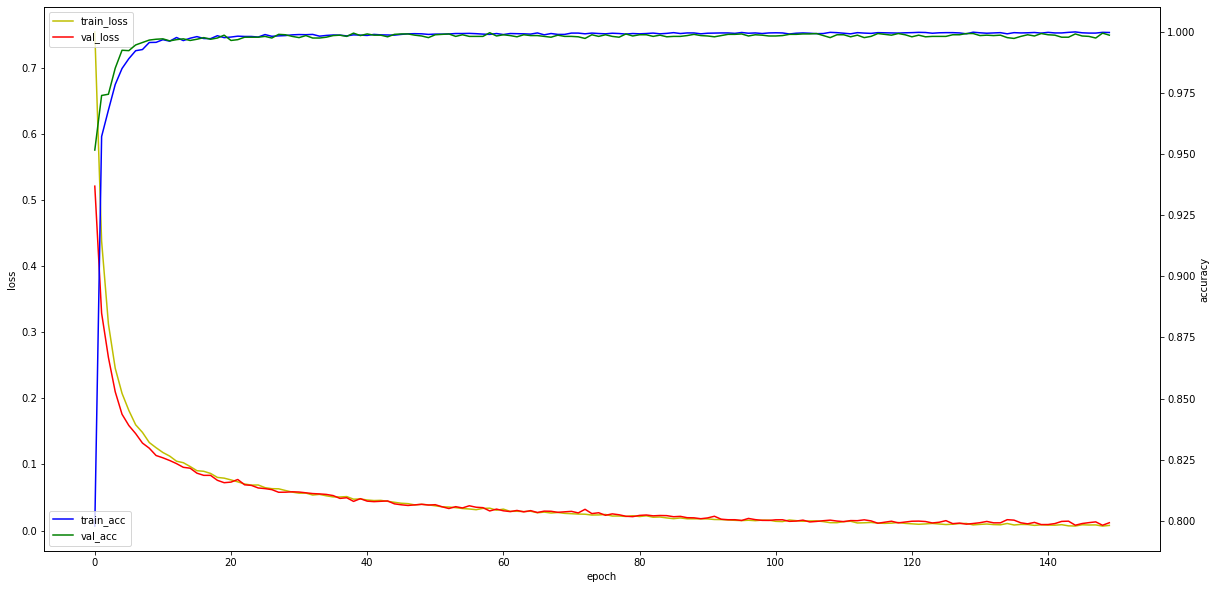

In [401]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [402]:
data_gen_train = pad_sequences(tidf_gen_train, maxlen=genvec_size, padding='pre')
#data_cond_train = pad_sequences(tidf_cond_train, maxlen=convec_size, padding='pre')
data_cond_train = np.array([x + [[]] * (9 - len(x)) for x in tidf_cond_train])
data_cond_train = [pad_sequences(x, maxlen=convec_size, padding='pre') for x in data_cond_train]
data_gen_valid = pad_sequences(tidf_gen_valid, maxlen=genvec_size, padding='pre')
#data_cond_valid = pad_sequences(tidf_cond_valid, maxlen=convec_size, padding='pre')
data_cond_valid = np.array([x + [[]] * (9 - len(x)) for x in tidf_cond_valid])
data_cond_valid = [pad_sequences(x, maxlen=convec_size, padding='pre') for x in data_cond_valid]

In [403]:
dct = np.swapaxes(data_cond_train, 0, 1)
dcv = np.swapaxes(data_cond_valid, 0, 1)

In [404]:
*_, train_acc = model.evaluate([dct[0], dct[1], dct[2], dct[3], dct[4], dct[5], dct[6], dct[7], dct[8], data_gen_train], tidf_label_train)
*_, valid_acc = model.evaluate([dcv[0], dcv[1], dcv[2], dcv[3], dcv[4], dcv[5], dcv[6], dcv[7], dcv[8], data_gen_valid], tidf_label_valid)
train_acc, valid_acc, '{:.3f}%'.format(valid_acc / train_acc * 100)

59281/59281 [==============================] - 17s 284us/step


(0.999938039688396, 0.9997807054536867, '99.984%')

In [405]:
data_gen_test = pad_sequences(tidf_gen_test, maxlen=genvec_size, padding='pre')
#data_cond_test = pad_sequences(tidf_cond_test, maxlen=convec_size, padding='pre')
data_cond_test = np.array([x + [[]] * (9 - len(x)) for x in tidf_cond_test])
data_cond_test = np.array([pad_sequences(x, maxlen=convec_size, padding='pre') for x in data_cond_test])
dctt = np.swapaxes(data_cond_test, 0, 1)

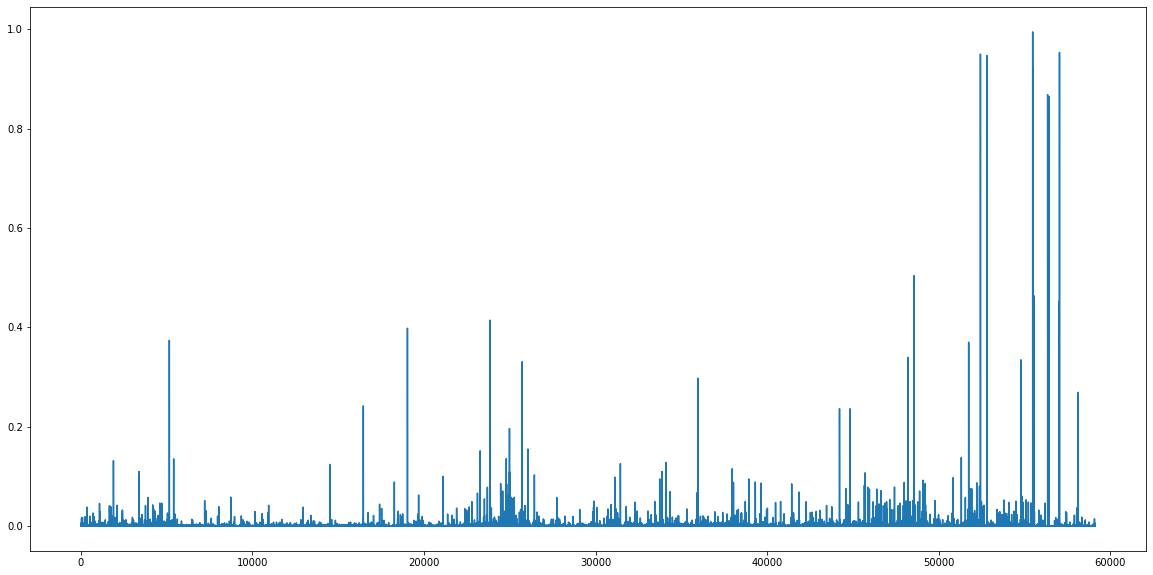

In [406]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[dctt[0], dctt[1], dctt[2], dctt[3], dctt[4], dctt[5], dctt[6], dctt[7], dctt[8], data_gen_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

auc : 0.9999948281940851


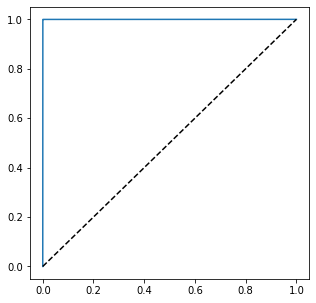

In [407]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [ ]:
# 제출 준비

In [408]:
submit_df = pd.read_csv('./data/public_test.csv')

In [409]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited = parse_sentence(item.text)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2020-01-03 16:01:35.603865 0


In [410]:
# smishing cases; length of vocab when it's out of vocab
submit_conditioned = []
submit_general = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in unknowns:
    submit_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    submit_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] if row[1] == False for x in row[2]])


size of vocab (conditioned, general): 17180 24102


In [413]:
data_gen_submit = pad_sequences(tidf_submit_general, maxlen=genvec_size, padding='pre')
data_cond_submit = np.array([x + [[]] * (9 - len(x)) for x in tidf_submit_cond])
data_cond_submit = np.array([pad_sequences(x, maxlen=convec_size, padding='pre') for x in data_cond_submit])
dcs = np.swapaxes(data_cond_submit, 0, 1)

NameError: name 'tidf_submit_general' is not defined

In [44]:
pred_y = model.predict(x=[dcs[0], dcs[1], dcs[2], dcs[3], dcs[4], dcs[5], dcs[6], dcs[7], dcs[8], data_gen_submit], verbose=1)

1626/1626 [==============================] - 0s 73us/step


In [45]:
pred_y[pred_y > 1.0] = 1.0

In [46]:
submit_df['smishing'] = np.abs(pred_y)

In [47]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20200103_1.csv', index=False)